In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

In [14]:
def hp(level, base_points):
    return (140 * 2 + 31 + base_points / 4) * level / 100 + 10 + level


def defense(level, base_points, modifier=1.0):
    return ((95 * 2 + 31 + base_points / 4) * level / 100 + 5) * modifier


def damage(level, attack, defense):
    return ((2 * level + 10) / 250) * attack / defense + 2


In [32]:
level = 100

defense_base_points = np.array(range(1, 129))

eternatus_hp_remained = []

ability_powers = [60, 80, 100, 120, 140, 160]
ability_powers = [200]

for power in ability_powers:
    attack = 300 * power
    # attack = np.array(range(100, 30100, 100))
    # defense_base_points, attack = np.meshgrid(defense_base_points, attack)

    hp_base_points = np.array([(252 - 2 * pts) for pts in defense_base_points])
    eternatus_defense = defense(level, defense_base_points)
    eternatus_hp = hp(level, hp_base_points)
    eternatus_damage = damage(level, attack, eternatus_defense)
    eternatus_hp_remained.append((eternatus_hp - eternatus_damage) / eternatus_hp)


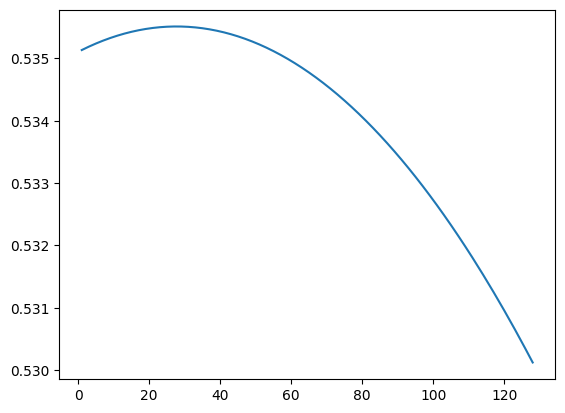

In [33]:
plt.figure()

for i, power in enumerate(ability_powers):
    plt.plot(defense_base_points, eternatus_hp_remained[i])

plt.show()


Optimal Defense Points: [tensor(5.7125), tensor(16.2542), tensor(20.9199), tensor(23.5520), tensor(25.2422), tensor(26.4194), tensor(27.2865), tensor(27.9516), tensor(28.4780), tensor(28.9050), tensor(29.2584), tensor(29.5554), tensor(29.8090), tensor(30.0277), tensor(30.2184), tensor(30.3861), tensor(30.5347), tensor(30.6673), tensor(30.7864), tensor(30.8938), tensor(30.9915), tensor(31.0802), tensor(31.1617), tensor(31.2365), tensor(31.3054), tensor(31.3692), tensor(31.4282), tensor(31.4832), tensor(31.5345), tensor(31.5824), tensor(31.6272), tensor(31.6694), tensor(31.7090), tensor(31.7464), tensor(31.7816), tensor(31.8148)]
Optimal Defense Points: [tensor(-6.8252), tensor(8.3042), tensor(15.1020), tensor(18.9648), tensor(21.4558), tensor(23.1959), tensor(24.4802), tensor(25.4669), tensor(26.2487), tensor(26.8835), tensor(27.4093), tensor(27.8517), tensor(28.2292), tensor(28.5553), tensor(28.8395), tensor(29.0896), tensor(29.3115), tensor(29.5093), tensor(29.6871), tensor(29.8477), 

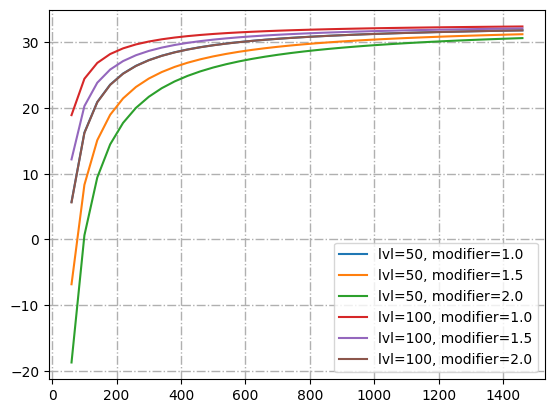

In [50]:
import matplotlib.pyplot as plt
import torch


C_HP_SPECIES_STRENGTH = 140
C_DEFENSE_SPECIES_STRENGTH = 95


class DamageCalculator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.defense_base_points = torch.nn.Parameter(torch.zeros(1))

    def forward(self, level, attack, modifier):
        hp_base_points = 256 - 2 * self.defense_base_points

        defense = (
            (C_DEFENSE_SPECIES_STRENGTH * 2 + 31 + self.defense_base_points / 4)
            * level
            / 100
            + 5
        ) * modifier
        hp = (
            (C_HP_SPECIES_STRENGTH * 2 + 31 + hp_base_points / 4) * level / 100
            + 10
            + level
        )
        damage = (2 * level + 10) / 250 * attack / defense + 2
        return damage / hp


ability_powers = list(range(60, 1500, 40))

plt.figure()


def _plot_optimal_defense_points(level, modifier):
    optimal_defense_points = []

    for power in ability_powers:
        calculator = DamageCalculator()
        optimizer = torch.optim.SGD(calculator.parameters(), lr=1e5)

        def _update():
            optimizer.zero_grad()
            loss = calculator(level, 3 * level * power, modifier)
            loss.backward()

            orig_defense_base_points = torch.clone(
                calculator.defense_base_points[0].detach()
            )

            optimizer.step()

            updated_defense_base_points = calculator.defense_base_points[0]
            return abs(orig_defense_base_points - updated_defense_base_points).detach()

        while True:
            if _update() < 1e-4:
                break

        optimal_defense_points.append(
            torch.clone(calculator.defense_base_points[0].detach())
        )

    print("Optimal Defense Points:", optimal_defense_points)

    plt.plot(
        ability_powers,
        optimal_defense_points,
        label=f"lvl={level}, modifier={modifier}",
    )


for level in [50, 100]:
    for modifier in [1.0, 1.5, 2.0]:
        _plot_optimal_defense_points(level, modifier)

plt.legend()
plt.grid(linestyle="-.", linewidth=1)
plt.show()
